# Cartpole Problem

The state and control vectors $\textbf{x}$ and $\textbf{u}$ are defined as follows:

$$
\begin{equation*}
\textbf{x} = \begin{bmatrix}
    x & \theta & \dot{x} & \dot{\theta}
    \end{bmatrix}^T
\end{equation*}
$$

$$
\begin{equation*}
\textbf{u} = \begin{bmatrix}
    F_{x}
    \end{bmatrix}^T
\end{equation*}
$$

The goal is to swing the pendulum upright:

$$
\begin{equation*}
\textbf{x}_{goal} = \begin{bmatrix}
    0 & 0 & 0 & 0
    \end{bmatrix}^T
\end{equation*}
$$

**Note**: The force is constrained between $-1$ and $1$. This is achieved by
instead fitting for unconstrained actions and then applying it to a squashing
function $\tanh(\textbf{u})$. This is directly embedded into the dynamics model
in order to be auto-differentiated. This also means that we need to apply this
transformation manually to the output of our iLQR at the end.

In [1]:
%matplotlib inline

In [2]:
from __future__ import print_function

In [3]:
import numpy as np
import matplotlib.pyplot as plt

In [4]:
from ilqr.cost import QRCost, FiniteDiffCost
from ilqr.mujoco_dynamics import MujocoDynamics
from ilqr.mujoco_controller import iLQR
from ilqr.examples.cartpole import CartpoleDynamics
from ilqr.dynamics import constrain

from scipy.optimize import approx_fprime

import mujoco_py
from mujoco_py import MjViewer
import os

In [5]:
def on_iteration(iteration_count, xs, us, J_opt, accepted, converged):
    J_hist.append(J_opt)
    info = "converged" if converged else ("accepted" if accepted else "failed")
    final_state = xs[-1]
    print("iteration", iteration_count, info, J_opt, final_state)

In [6]:
xml_path = os.path.join('..', 'ilqr', 'xmls', 'inverted_pendulum.xml')
dynamics = MujocoDynamics(xml_path, frame_skip = 2, x_eps = np.sqrt(np.finfo(float).eps), u_eps = np.sqrt(np.finfo(float).eps))
print(dynamics.dt)


0.04


In [151]:
x_goal = np.array([0.0, 0.0, 0.0, 0.0])

# Instantenous state cost.
Q = np.eye(4)
Q[0, 0] = 10.0
Q[1, 1] = 10.0


# Terminal state cost.
Q_terminal = 10 * Q

# Instantaneous control cost.
R = 10 * np.eye(1)

cost1 = QRCost(Q, R, Q_terminal=Q_terminal, x_goal=x_goal)

In [152]:
"""cost2 = FiniteDiffCost(lambda x, u, i: x[0]*(x[0]+np.sin(x[1])) + np.sin(x[1])*(x[0] + np.sin(x[1])) + (np.cos(x[1]) - 1) * (np.cos(x[1])-1) + 0.1 * u[0] * u[0],
                      lambda x, i: 100 * (x[0]**2 + x[2]**2 + np.sin(x[1])**2 + (np.cos(x[1]) - 1)**2 + x[3]**2),
                      4, 1, x_eps = 1e-6, u_eps = 1e-6)

print(cost1.l([1.0,0.5,np.sin(0.37),np.cos(0.37),3.0], [0.5], 0))
print(cost2.l([1.0,0.37,0.5,3.0], [0.5], 0))"""

'cost2 = FiniteDiffCost(lambda x, u, i: x[0]*(x[0]+np.sin(x[1])) + np.sin(x[1])*(x[0] + np.sin(x[1])) + (np.cos(x[1]) - 1) * (np.cos(x[1])-1) + 0.1 * u[0] * u[0],\n                      lambda x, i: 100 * (x[0]**2 + x[2]**2 + np.sin(x[1])**2 + (np.cos(x[1]) - 1)**2 + x[3]**2),\n                      4, 1, x_eps = 1e-6, u_eps = 1e-6)\n\nprint(cost1.l([1.0,0.5,np.sin(0.37),np.cos(0.37),3.0], [0.5], 0))\nprint(cost2.l([1.0,0.37,0.5,3.0], [0.5], 0))'

In [164]:
N = 100
x0 = np.array([0.0, 0.7, 0.0, 0.0])
us_init = np.random.uniform(-1, 1, (N, dynamics.action_size))
ilqr = iLQR(dynamics, cost1, N)

In [165]:
J_hist = []
xs, us = ilqr.fit(x0, us_init, n_iterations=500, on_iteration=on_iteration)

iteration 0 accepted 9816.825800512448 [-0.79811096  2.04256238 -3.6282312   0.66189747]
iteration 1 accepted 9530.291956002988 [-0.54284822  2.1224443  -2.32239802  1.20818226]
iteration 2 accepted 9432.130249997435 [-0.5889337   1.89024586 -2.58368131  1.02456715]
iteration 3 accepted 9406.356793372292 [-0.5860417   1.84953383 -2.00526914  1.13167529]
iteration 4 accepted 9379.566069180306 [-0.61273021  1.71995722 -1.95249903  1.03234812]
iteration 5 accepted 9361.685844246227 [-0.60023498  1.67828696 -1.56752982  1.07247544]
iteration 6 accepted 9348.05714268188 [-0.62678335  1.57066001 -1.45976799  0.9475594 ]
iteration 7 accepted 9325.495654397699 [-0.60408253  1.53156248 -1.08225696  0.96342452]
iteration 8 accepted 9315.071972099555 [-0.63433934  1.42951968 -0.97542364  0.77793334]
iteration 9 accepted 9278.766078100543 [-0.59652295  1.38856911 -0.58347835  0.77543532]
iteration 10 accepted 9269.607396134043 [-0.64371503  1.27876521 -0.48903243  0.47946269]
iteration 11 accepted

iteration 93 accepted 6928.451964052593 [ 0.04039686 -0.01277472  0.39647209  0.1804459 ]
iteration 94 accepted 6890.3331920325945 [ 0.05022991 -0.01747799  0.41651875  0.19231224]
iteration 95 accepted 6860.884928440026 [ 0.09160498 -0.0123889   0.38126071  0.18395907]
iteration 96 accepted 6843.105054386832 [ 0.02178056 -0.02224282  0.40379911  0.18277447]
iteration 97 accepted 6823.723891683046 [ 0.02937807 -0.02156722  0.38603664  0.176536  ]
iteration 98 accepted 6803.157003572876 [ 0.06478863 -0.01818099  0.37329439  0.1770732 ]
iteration 99 accepted 6784.36272127201 [ 0.12921198 -0.00750502  0.29900192  0.15497921]
iteration 100 accepted 6772.000408427308 [ 0.08593187 -0.01546543  0.34111681  0.16674978]
iteration 101 accepted 6745.995747845389 [ 0.07133693 -0.0163094   0.3209802   0.1555699 ]
iteration 102 accepted 6703.626311627191 [ 0.06798834 -0.01732451  0.32357556  0.15632069]
iteration 103 accepted 6664.085328443613 [ 0.02298978 -0.01997753  0.3034154   0.13970734]
iterat

iteration 183 accepted 4136.5157894296935 [ 0.00429624 -0.00923534  0.04566031  0.02329535]
iteration 184 accepted 4085.995738284242 [ 0.00399017 -0.00930213  0.04631687  0.02353438]
iteration 185 accepted 4085.0389854680916 [ 0.01194993 -0.00098436 -0.01419095 -0.00311475]
iteration 186 accepted 3995.4405291020535 [ 0.01521609  0.00370297 -0.04621504 -0.01749271]
iteration 187 accepted 3953.2362569346387 [ 0.01048174 -0.00157774 -0.00877108 -0.00092307]
iteration 188 accepted 3911.7699922544953 [ 0.00723777 -0.00492611  0.01569291  0.00984144]
iteration 189 accepted 3870.718170711777 [ 0.00669725 -0.00619114  0.02337638  0.01338173]
iteration 190 accepted 3859.610287415662 [ 0.00901998 -0.00158282 -0.00680945 -0.0003771 ]
iteration 191 accepted 3805.90004218993 [ 0.01219424  0.0031827  -0.03947892 -0.01507054]
iteration 192 accepted 3742.7586084966933 [ 0.01238911  0.00669031 -0.05881306 -0.02430791]
iteration 193 accepted 3682.0714100043187 [ 0.01152904  0.00564888 -0.05162243 -0.021

iteration 273 accepted 2661.0719585697184 [ 0.00087996  0.00067584 -0.00623412 -0.00242401]
iteration 274 accepted 2657.124938461972 [ 0.0007898   0.00074342 -0.00642535 -0.00254351]
iteration 275 accepted 2655.5912079202176 [ 0.00078565  0.00073632 -0.0063779  -0.00252203]
iteration 276 accepted 2653.775464106553 [ 0.0007302   0.00077049 -0.00645028 -0.00257408]
iteration 277 accepted 2653.1339794695086 [ 0.00072966  0.00076441 -0.0064155  -0.00255757]
iteration 278 accepted 2652.2308301731405 [ 0.00070026  0.00077727 -0.00642301 -0.00257046]
iteration 279 accepted 2651.929175166838 [ 0.00070639  0.00076819 -0.00638592 -0.00255074]
iteration 280 accepted 2651.4037617288504 [ 0.00068863  0.00077319 -0.00637451 -0.00255092]
iteration 281 accepted 2651.22927903697 [ 0.00069642  0.00076451 -0.00634354 -0.0025336 ]
iteration 282 accepted 2650.8839738290144 [ 0.00068342  0.00076722 -0.00632977 -0.00253114]
iteration 283 accepted 2650.7609626147437 [ 0.0006907   0.00075998 -0.00630597 -0.002

In [166]:
t = np.arange(N + 1) * dynamics.dt
x = xs[:, 0]
x_dot = xs[:, 2]
theta = np.unwrap(xs[:, 1])  # Makes for smoother plots.
theta_dot = xs[:, 3]

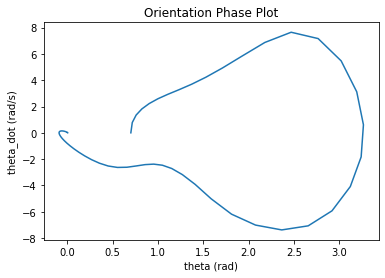

In [167]:
_ = plt.plot(theta, theta_dot)
_ = plt.xlabel("theta (rad)")
_ = plt.ylabel("theta_dot (rad/s)")
_ = plt.title("Orientation Phase Plot")

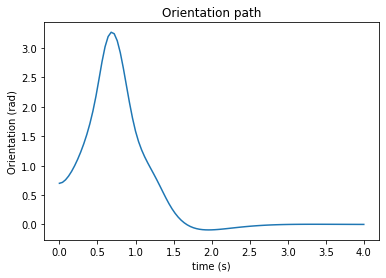

In [168]:
_ = plt.plot(t, theta)
_ = plt.xlabel("time (s)")
_ = plt.ylabel("Orientation (rad)")
_ = plt.title("Orientation path")

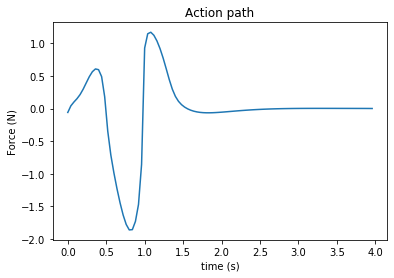

In [169]:
_ = plt.plot(t[:-1], us)
_ = plt.xlabel("time (s)")
_ = plt.ylabel("Force (N)")
_ = plt.title("Action path")

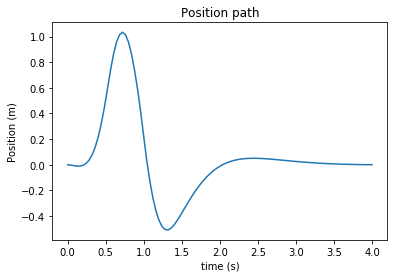

In [170]:
_ = plt.plot(t, x)
_ = plt.xlabel("time (s)")
_ = plt.ylabel("Position (m)")
_ = plt.title("Position path")

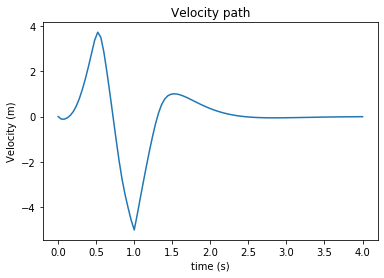

In [171]:
_ = plt.plot(t, x_dot)
_ = plt.xlabel("time (s)")
_ = plt.ylabel("Velocity (m)")
_ = plt.title("Velocity path")

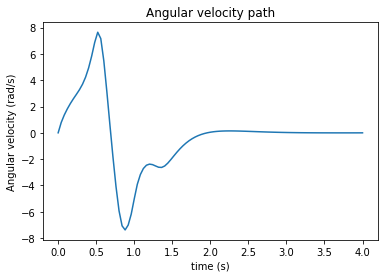

In [172]:
_ = plt.plot(t, theta_dot)
_ = plt.xlabel("time (s)")
_ = plt.ylabel("Angular velocity (rad/s)")
_ = plt.title("Angular velocity path")

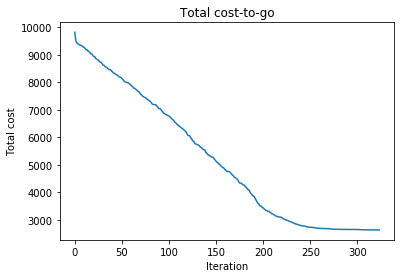

In [173]:
_ = plt.plot(J_hist)
_ = plt.xlabel("Iteration")
_ = plt.ylabel("Total cost")
_ = plt.title("Total cost-to-go")

In [174]:
viewer = MjViewer(dynamics.sim)
dynamics.set_state(x0)
print(dynamics.get_state())
for i, u in enumerate(us):
    print (i, u)
    print(xs[i+1], dynamics.step(u))
    print('')
    viewer.render()

Creating window glfw
[0.  0.7 0.  0. ]
0 [-0.05976086]
[-0.00223066  0.71584009 -0.11035109  0.78280995] [-0.00223066  0.71584009 -0.11035109  0.78280995]

1 [0.04146418]
[-0.00676497  0.75858874 -0.11525241  1.35138262] [-0.00676497  0.75858874 -0.11525241  1.35138262]

2 [0.10019289]
[-0.01024148  0.82193215 -0.0575334   1.81698609] [-0.01024148  0.82193215 -0.0575334   1.81698609]

3 [0.15140273]
[-0.01033273  0.90265195  0.05402163  2.22387748] [-0.01033273  0.90265195  0.05402163  2.22387748]

4 [0.21435113]
[-0.0047101   0.99872873  0.2281978   2.58862473] [-0.0047101   0.99872873  0.2281978   2.58862473]

5 [0.29673475]
[0.00940514 1.10881546 0.47874532 2.92865513] [0.00940514 1.10881546 0.47874532 2.92865513]

6 [0.39317967]
[0.03520548 1.23263716 0.81279247 3.27987938] [0.03520548 1.23263716 0.81279247 3.27987938]

7 [0.4881736]
[0.07593549 1.3717035  1.22608599 3.69522155] [0.07593549 1.3717035  1.22608599 3.69522155]

8 [0.56455126]
[0.13453237 1.52969256 1.70771967 4.230295

73 [0.00072582]
[ 0.02811387 -0.00111529 -0.05424242  0.02769079] [ 0.02811387 -0.00111529 -0.05424242  0.02769079]

74 [0.0012263]
[ 0.02597766 -0.00010448 -0.05259751  0.02312629] [ 0.02597766 -0.00010448 -0.05259751  0.02312629]

75 [0.0016338]
[ 0.02391295  0.00073364 -0.05066256  0.01901456] [ 0.02391295  0.00073364 -0.05066256  0.01901456]

76 [0.00195858]
[ 0.02193002  0.00141671 -0.04850556  0.01533584] [ 0.02193002  0.00141671 -0.04850556  0.01533584]

77 [0.00221026]
[ 0.02003654  0.00196152 -0.046186    0.0120675 ] [ 0.02003654  0.00196152 -0.046186    0.0120675 ]

78 [0.00239782]
[ 0.018238    0.00238393 -0.04375546  0.00918493] [ 0.018238    0.00238393 -0.04375546  0.00918493]

79 [0.00252958]
[ 0.01653797  0.00269877 -0.04125829  0.00666224] [ 0.01653797  0.00269877 -0.04125829  0.00666224]

80 [0.0026132]
[ 0.01493835  0.00291986 -0.03873227  0.00447297] [ 0.01493835  0.00291986 -0.03873227  0.00447297]

81 [0.00265567]
[ 0.01343966  0.00305994 -0.03620917  0.00259049] [

In [58]:
print(dynamics.get_state())
print(xs[-1])

[-0.08880678 -4.20373634 -0.00524991 -0.24352234]
[ 0.00098965 -0.00137713  0.00011993  0.00062502]


In [ ]:
#FOR TESTING PURPOSES

In [25]:
dynamics1 = MujocoDynamics(xml_path, frame_skip = 2, bounds = np.array([[-1, 1]]), x_eps = np.sqrt(np.finfo(float).eps), u_eps = np.sqrt(np.finfo(float).eps))
dynamics2 = CartpoleDynamics(0.04)

In [27]:
np.set_printoptions(precision = 4, suppress = True, floatmode = 'fixed')

dynamics1.set_state(np.array([0.1, 2.3, 0.3, 0.6]))
nextstate = dynamics1.step([0.0])
print(np.array([nextstate[0], nextstate[2], np.sin(nextstate[1]), np.cos(nextstate[1]), nextstate[3]]))
print('')
print(dynamics1.f_x(np.array([0.0, 0.0, 0.0, 0.0]), np.array([0.0])))
print('\n\n\n')


print(dynamics2.f(np.array([0.1, 0.3, np.sin(2.3), np.cos(2.3), 0.6]), np.array([0.0]), 0))
print('')

def helper(x, u, i):
    x = np.array([x[0], x[2], np.sin(x[1]), np.cos(x[1]), x[3]])
    #print(x)
    
    result = dynamics2.f(x, u, i)[0]
    result = np.array([result[0], np.arctan2(result[2], result[3]), result[1], result[4]])
    
    #print(result)
    return result


J = np.vstack([
        approx_fprime(np.array([0.0, 2.3, 0.0, 0.0]), lambda x: helper(x, np.array([0.0]), 0)[m], np.sqrt(np.finfo(float).eps))
        for m in range(4)
    ])
print(J)


[ 0.1130  0.3513  0.7196 -0.6944  1.3076]

[[ 1.0000 -0.0015  0.0399  0.0001]
 [ 0.0000  1.0142  0.0002  0.0386]
 [ 0.0000 -0.0926  0.9963  0.0062]
 [ 0.0000  0.9036  0.0085  0.9391]]




[[ 0.1120  0.3147  0.7295 -0.6840  0.8267]]

[[ 1.0000  0.0000  0.0400  0.0000]
 [ 0.0000  1.0000  0.0000  0.0400]
 [ 0.0000  0.0041  1.0000  0.0000]
 [ 0.0000 -0.1863  0.0000  1.0000]]


In [1]:
np.sqrt(np.finfo(float).eps)

NameError: name 'np' is not defined